Risk Distribution Summary:
count    777.000000
mean      35.271003
std       32.440248
min       19.508386
25%       19.508386
50%       19.508386
75%       23.011710
max      108.185751
Name: Risk, dtype: float64

Key Performance Indicators

1. Risk Profile by Category:
 Category  Average Risk  Risk Volatility
   Liquid     19.508386              0.0
    Other    108.185751              0.0
Overnight     23.011710              0.0

2. NAV Statistics by Category:
 Category    Mean_NAV  Median_NAV     NAV_Std     NAV_Range
   Liquid 1251.286760   1005.7033 1189.771738  1.00-6452.56
    Other   12.675010     12.4495    1.037545   11.82-16.70
Overnight 1074.009157   1005.1627  573.643336 10.00-4211.22

3. Risk-NAV Correlation Matrix:
                     Risk  Net Asset Value
Risk             1.000000        -0.433302
Net Asset Value -0.433302         1.000000

4. Risk Level Distribution:
Risk Level  Percentage
       Low        83.5
      High        16.5
    Medium         0.0

5. Plan 

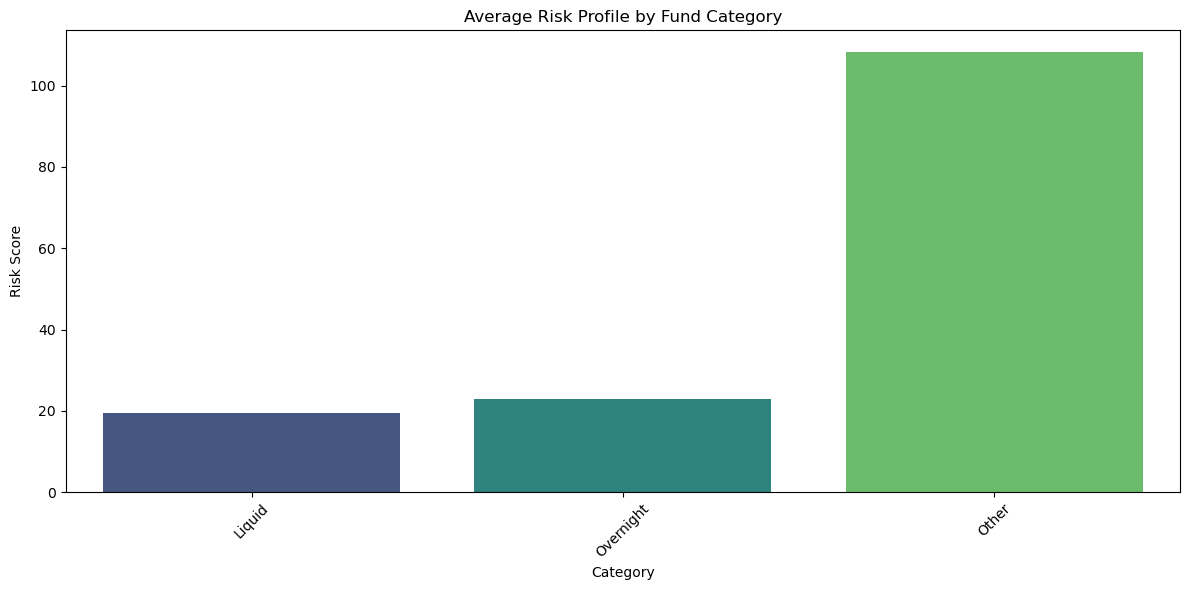

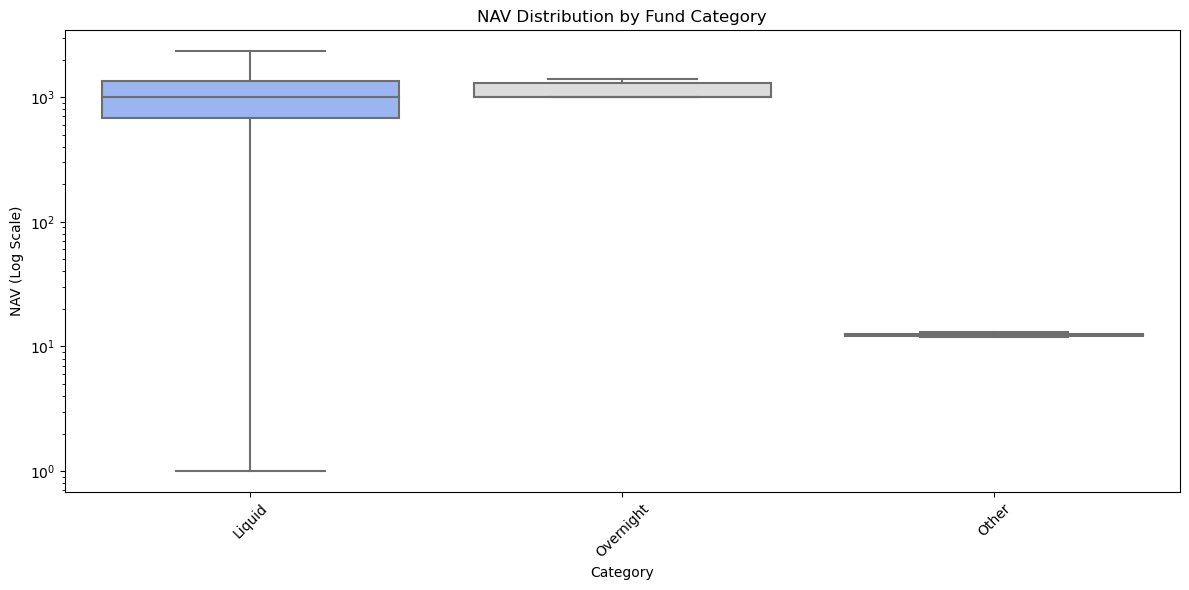

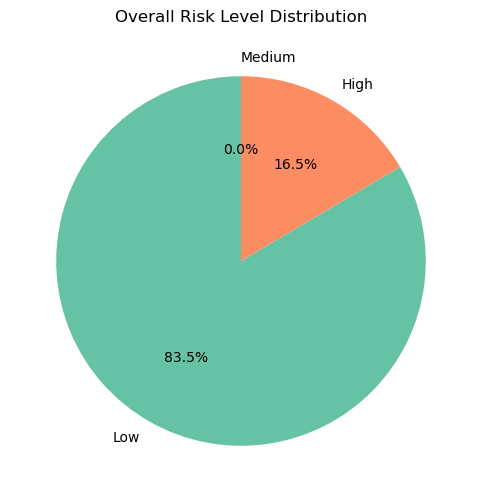

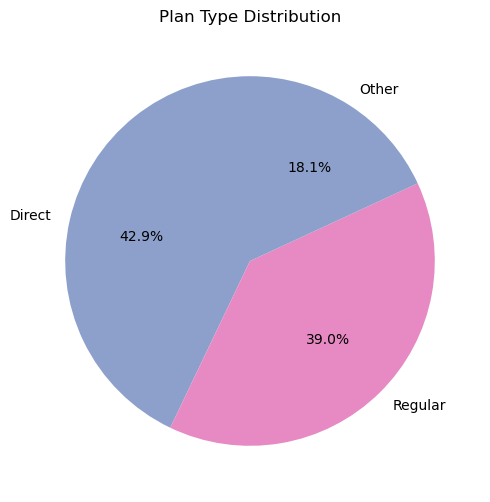


Fund Recommendations

Low risk recommendations:
                                            Scheme Name  Net Asset Value  \
1447  Nippon India Liquid Fund - Direct Plan Growth ...        6452.5569   
1389           Kotak Liquid Fund - Direct Plan - Growth        5326.3788   
1289     HDFC Liquid Fund - Growth Option - Direct Plan        5177.6210   
1393              LIC MF Liquid Fund-Direct Plan-Growth        4786.1274   
1596  UTI-  Liquid Cash Plan - Direct Plan - Growth ...        4321.1276   

           Risk Category  
1447  19.508386   Liquid  
1389  19.508386   Liquid  
1289  19.508386   Liquid  
1393  19.508386   Liquid  
1596  19.508386   Liquid  

Medium risk recommendations:
                                            Scheme Name  Net Asset Value  \
1447  Nippon India Liquid Fund - Direct Plan Growth ...        6452.5569   
1389           Kotak Liquid Fund - Direct Plan - Growth        5326.3788   
1289     HDFC Liquid Fund - Growth Option - Direct Plan        5177.6210  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess_data(file_path):
    df = pd.read_excel('C:/Users/manav/Dropbox/PC/Downloads/mutual_fund_nav.xlsx', sheet_name='Sheet1')
    
    # Convert Date and filter for latest NAVs
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    latest_date = df['Date'].max()
    df = df[df['Date'] == latest_date].copy()
    
    # Enhanced category detection
    def get_category(name):
        name = name.lower()
        categories = {
            'liquid': 'Liquid',
            'overnight': 'Overnight',
            'money market': 'Money Market',
            'banking & psu': 'Banking & PSU Debt',
            'corporate bond': 'Corporate Bond',
            'credit risk': 'Credit Risk',
            'dynamic bond': 'Dynamic Bond',
            'floating rate': 'Floating Rate',
            'floater': 'Floating Rate',
            'gilt': 'Gilt',
            'medium duration': 'Medium Duration',
            'short duration': 'Short Duration'
        }
        for key, value in categories.items():
            if key in name:
                return value
        return 'Other'
    
    df['Category'] = df['Scheme Name'].apply(get_category)
    
    # Enhanced plan type detection
    def get_plan_type(name):
        name = name.lower()
        if 'direct' in name:
            return 'Direct'
        elif 'regular' in name or 'retail' in name:
            return 'Regular'
        return 'Other'
    
    df['Plan_Type'] = df['Scheme Name'].apply(get_plan_type)
    
    return df

def calculate_risk_profiles(df):
    """Calculate risk profiles based on category characteristics"""
    # Define base risk scores for each category
    category_risk_scores = {
        'Liquid': 10,
        'Overnight': 15,
        'Money Market': 20,
        'Banking & PSU Debt': 40,
        'Corporate Bond': 60,
        'Short Duration': 70,
        'Medium Duration': 90,
        'Floating Rate': 50,
        'Dynamic Bond': 80,
        'Credit Risk': 120,
        'Gilt': 30,
        'Other': 100
    }
    
    # Apply base risk scores
    df['Base_Risk'] = df['Category'].map(category_risk_scores)
    
    # Adjust risk based on NAV volatility within category
    nav_stats = df.groupby('Category')['Net Asset Value'].agg(['std', 'mean'])
    nav_stats['CoV'] = nav_stats['std'] / nav_stats['mean']
    
    # Final risk score combines base risk and volatility
    df['Risk'] = df['Base_Risk'] * (1 + df['Category'].map(nav_stats['CoV']).fillna(0))
    
    return df

def calculate_kpis(df):
    """Calculate Key Performance Indicators for fund analysis"""
    # KPI 1: Risk Distribution by Category
    risk_by_category = df.groupby('Category')['Risk'].agg(['mean', 'std']).reset_index()
    risk_by_category = risk_by_category.rename(columns={
        'mean': 'Average Risk',
        'std': 'Risk Volatility'
    })
    
    # KPI 2: NAV Distribution Metrics
    nav_stats = df.groupby('Category')['Net Asset Value'].agg(
        Mean_NAV='mean',
        Median_NAV='median',
        NAV_Std='std',
        NAV_Range=lambda x: f"{x.min():.2f}-{x.max():.2f}"
    ).reset_index()
    
    # KPI 3: Risk-NAV Correlation Matrix
    correlation = df[['Risk', 'Net Asset Value']].corr()
    
    # KPI 4: Risk Category Distribution
    bins = [0, 50, 100, np.inf]
    labels = ['Low', 'Medium', 'High']
    risk_series = pd.cut(df['Risk'], bins=bins, labels=labels)
    risk_distribution = risk_series.value_counts(normalize=True).reset_index()
    risk_distribution.columns = ['Risk Level', 'Percentage']
    risk_distribution['Percentage'] = (risk_distribution['Percentage'] * 100).round(1)
    
    # KPI 5: Plan Type Distribution
    plan_distribution = df['Plan_Type'].value_counts(normalize=True).reset_index()
    plan_distribution.columns = ['Plan Type', 'Percentage']
    plan_distribution['Percentage'] = (plan_distribution['Percentage'] * 100).round(1)
    
    return {
        'risk_by_category': risk_by_category,
        'nav_stats': nav_stats,
        'correlation_matrix': correlation,
        'risk_distribution': risk_distribution,
        'plan_distribution': plan_distribution
    }

def visualize_kpis(df, kpis):
    """Create visualizations for KPIs"""
    # Visualization 1: Risk Distribution by Category
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x='Category', 
        y='Average Risk', 
        data=kpis['risk_by_category'].sort_values('Average Risk'),
        palette='viridis'
    )
    plt.title('Average Risk Profile by Fund Category')
    plt.xticks(rotation=45)
    plt.ylabel('Risk Score')
    plt.tight_layout()
    plt.show()
    
    # Visualization 2: NAV Distribution
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='Category', 
        y='Net Asset Value', 
        data=df,
        showfliers=False,
        palette='coolwarm'
    )
    plt.title('NAV Distribution by Fund Category')
    plt.xticks(rotation=45)
    plt.yscale('log')  # Use log scale for better visualization
    plt.ylabel('NAV (Log Scale)')
    plt.tight_layout()
    plt.show()
    
    # Visualization 3: Risk Level Distribution
    plt.figure(figsize=(8, 6))
    plt.pie(
        kpis['risk_distribution']['Percentage'],
        labels=kpis['risk_distribution']['Risk Level'],
        autopct='%1.1f%%',
        colors=['#66c2a5', '#fc8d62', '#e78ac3'],
        startangle=90
    )
    plt.title('Overall Risk Level Distribution')
    plt.show()
    
    # Visualization 4: Plan Type Distribution
    plt.figure(figsize=(8, 6))
    plt.pie(
        kpis['plan_distribution']['Percentage'],
        labels=kpis['plan_distribution']['Plan Type'],
        autopct='%1.1f%%',
        colors=['#8da0cb', '#e78ac3'],
        startangle=90
    )
    plt.title('Plan Type Distribution')
    plt.show()

def recommend_funds(df, risk_tolerance='Medium', plan_type='Direct', option='Growth', top_n=5):
    """Enhanced recommendation function with dynamic risk ranges"""
    # Dynamic risk range calculation
    risk_values = df['Risk'].dropna()
    q_low = risk_values.quantile(0.25)
    q_high = risk_values.quantile(0.75)
    
    risk_ranges = {
        'Low': (0, q_low),
        'Medium': (q_low, q_high),
        'High': (q_high, risk_values.max())
    }
    
    low_bound, high_bound = risk_ranges.get(risk_tolerance, (0, np.inf))
    
    # Filter funds
    filtered = df[
        (df['Risk'].between(low_bound, high_bound)) &
        (df['Plan_Type'] == plan_type) &
        (df['Scheme Name'].str.contains(option, case=False))
    ].copy()
    
    if filtered.empty:
        print(f"No funds found for {risk_tolerance} risk tolerance.")
        return pd.DataFrame()
    
    # Calculate quality score
    filtered['Score'] = filtered['Net Asset Value'] / (filtered['Risk'] + 1)
    
    return filtered.nlargest(top_n, 'Score')[['Scheme Name', 'Net Asset Value', 'Risk', 'Category']]

# Main execution
if __name__ == "__main__":
    try:
        file_path = 'C:/Users/manav/Dropbox/PC/Downloads/mutual_fund_nav.xlsx'
        df = load_and_preprocess_data(file_path)
        df = calculate_risk_profiles(df)
        
        print("="*50)
        print("Risk Distribution Summary:")
        print(df['Risk'].describe())
        
        # Calculate and display KPIs
        kpis = calculate_kpis(df)
        
        print("\n" + "="*50)
        print("Key Performance Indicators")
        print("="*50)
        
        print("\n1. Risk Profile by Category:")
        print(kpis['risk_by_category'].to_string(index=False))
        
        print("\n2. NAV Statistics by Category:")
        print(kpis['nav_stats'].to_string(index=False))
        
        print("\n3. Risk-NAV Correlation Matrix:")
        print(kpis['correlation_matrix'])
        
        print("\n4. Risk Level Distribution:")
        print(kpis['risk_distribution'].to_string(index=False))
        
        print("\n5. Plan Type Distribution:")
        print(kpis['plan_distribution'].to_string(index=False))
        
        # Generate visualizations
        visualize_kpis(df, kpis)
        
        print("\n" + "="*50)
        print("Fund Recommendations")
        print("="*50)
        
        print("\nLow risk recommendations:")
        print(recommend_funds(df, 'Low'))
        
        print("\nMedium risk recommendations:")
        print(recommend_funds(df, 'Medium'))
        
        print("\nHigh risk recommendations:")
        print(recommend_funds(df, 'High'))
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")